In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 4*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-03-02 15:14:43.288227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 15:14:43.444162: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-02 15:14:44.177707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


2023-03-02 15:14:45.814287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 15:14:46.659160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [2]:
from local_utils import *

In [3]:
import pandas as pd
df_params = pd.read_pickle("../../bacterialcolony_dataset3/turing_df_circuit2_variant1_1000000parametersets.pkl")

In [4]:
df_params.head()

,DA,DB,bA,bB,bC,bD,bE,bF,VA,VB,...,nfe,nee,neb,nce,ss_n,ss_list,ss_class,system_class,maxeig,complex_dispersion
404,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,615.268976,73.210081,...,4.0,4.0,4.0,1.0,2.0,"[0.1997, 0.039, 10.9848, 104.771, 244.7529, 3....",stable spiral,turing I oscillatory,0.004898+0.036487j,True
2726,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,228.017071,94.502643,...,4.0,4.0,4.0,1.0,2.0,"[83.3645, 0.276, 12736.8586, 66.0485, 579.5646...",stable spiral,turing I oscillatory,0.000114+0.002647j,True
3508,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,23.538028,320.885489,...,4.0,4.0,4.0,1.0,3.0,"[6.9465, 0.1825, 57.5198, 3.3825, 131.0374, 1....",stable spiral,turing I oscillatory,0.001639+0.132134j,True
7516,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,16.205693,83.166774,...,4.0,4.0,4.0,1.0,1.0,"[1.7525, 0.2247, 908.552, 10.6864, 225.1614, 2...",stable spiral,turing I oscillatory,0.000652+0.003066j,True
7883,1.0,0.001,0.01,0.01,0.01,0.01,0.01,0.01,85.164519,738.495294,...,4.0,4.0,4.0,1.0,2.0,"[2.8165, 0.0136, 82.5102, 2.7508, 154.2711, 3....",stable spiral,turing I oscillatory,0.001346+0.016362j,True


In [5]:
import pickle

with open('../../bacterialcolony_dataset3/2Dfinal_circuit2_variant1_bc1.7_ca_ID546780_L8_J160_T125_N2500.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


In [6]:
ID = 546780
L = 8
data = np.array(ds_1)[:, :, :, np.newaxis]
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T=1
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
dxdy = x_size*y_size/L**2
N = x_size*y_size    
t_star = np.arange(T, T+1)

##########################
# select a subset of data
#t_star = t_star[-4:]
#T = len(t_star)
#data = data[:, :, :, -4::]

x_slice = slice(65, 100, 1)
y_slice = slice(65, 100, 1)

#data = data[:, x_slice, y_slice, np.newaxis]
#x_size = data.shape[1]
#y_size = data.shape[2]
#T = 1#data.shape[3]



indices_sub = indices_all[:, x_slice, y_slice]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


maxs = np.array([np.max(data[i, :, :, :]) for i in range(data.shape[0])])
mins = np.array([np.min(data[i, :, :, :]) for i in range(data.shape[0])])

In [7]:
df_params.loc[ID,:]

DA                                                                  1.0
DB                                                                0.001
bA                                                                 0.01
bB                                                                 0.01
bC                                                                 0.01
bD                                                                 0.01
bE                                                                 0.01
bF                                                                 0.01
VA                                                            46.733347
VB                                                           134.697819
VC                                                            53.677758
VD                                                            44.231763
VE                                                            943.26562
VF                                                           605

In [20]:
data.shape

(6, 160, 160, 1)

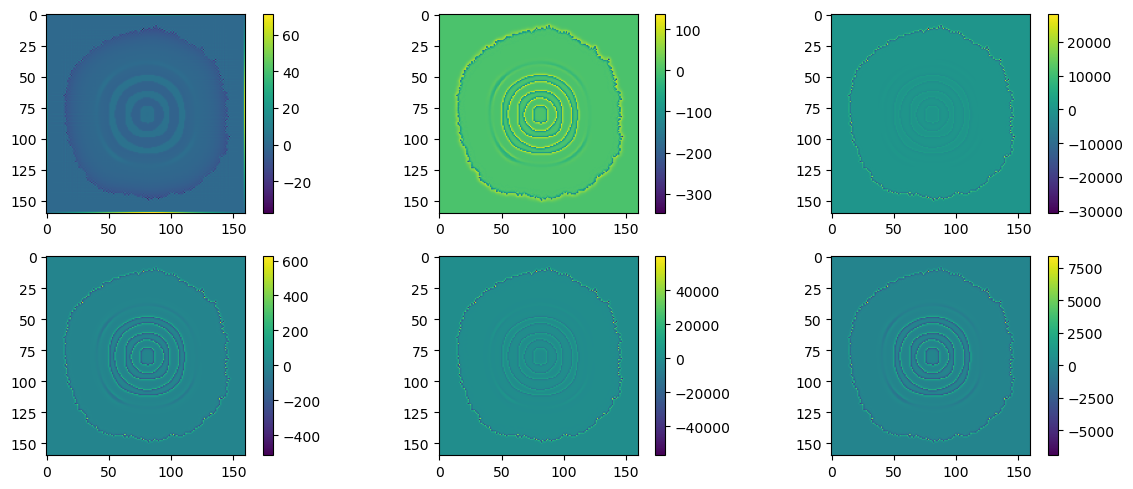

In [21]:
c_xx =  np.array([[ dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                        for t in range(data.shape[3])]
                        for c in range(data.shape[0])
                       ])
c_xx = np.einsum("ctij -> cijt", c_xx)
c_yy = np.array([[ dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

# c_t = np.array([[(data_time[c, ..., t+1] -  data_time[c, ..., t])/(t_star_time[t+1] - t_star_time[t])
#                     for t in range(data.shape[3])]
#                     for c in range(data.shape[0])
#                    ])
# c_t = np.einsum("ctij -> cijt", c_t)

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow((c_xx[i,:, : , -1] + c_yy[i,:, : , -1]))
    plt.colorbar()
plt.tight_layout();plt.show()


In [22]:
c_xx.shape

(6, 160, 160, 1)

In [23]:
data.shape

(6, 160, 160, 1)

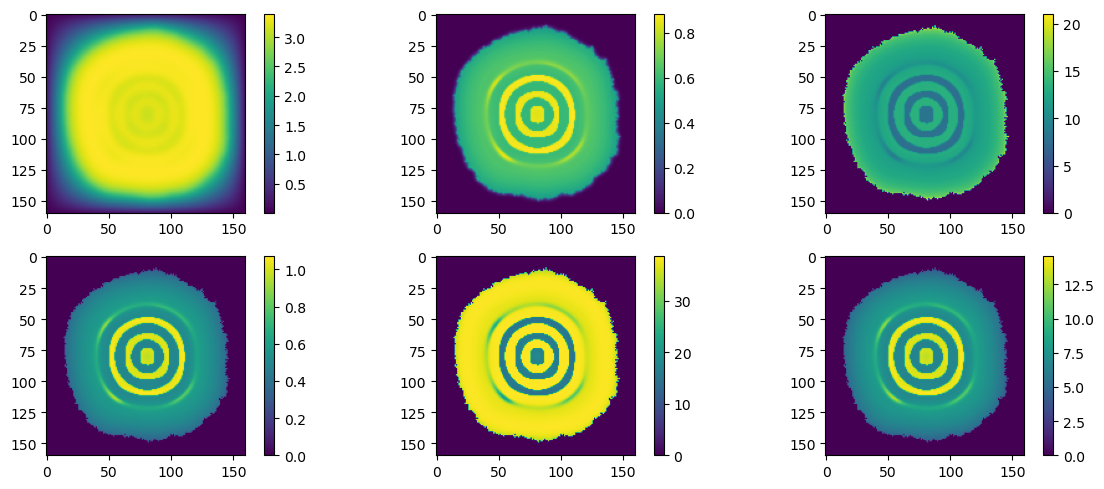

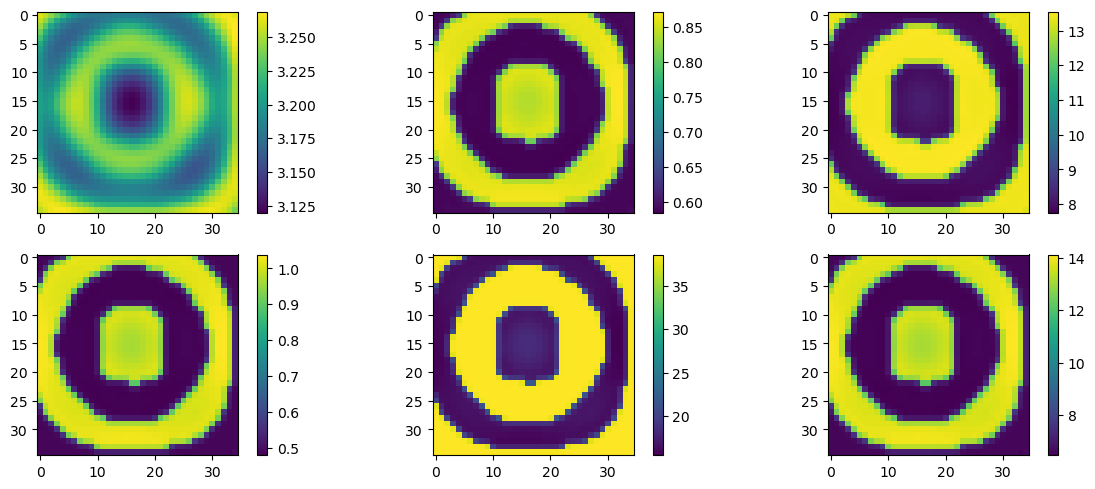

In [24]:
A = data[0, :, :, -1]
B = data[1, :, :, -1]
C = data[2, :, :, -1]
D = data[3, :, :, -1]
E = data[4, :, :, -1]
F = data[5, :, :, -1]

def activate(x, km, n=2):
    act = 1 / (1 + (km / (x + 1e-20)) ** (n))
    return act

def inhibit(x, km, n=2):
    inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
    return inh

params = df_params.loc[ID, :]
DA = params.DA    
DB = params.DB
bA = params.bA
bB = params.bB
bC = params.bC
bD = params.bD
bE = params.bE
bF = params.bF
VA = params.VA
VB = params.VB
VC = params.VC
VD = params.VD
VE = params.VE
VF = params.VF
Kab = params.Kab
Kbd = params.Kbd
Kce = params.Kce
Kda = params.Kda
Keb = params.Keb
Kee = params.Kee
Kfe = params.Kfe
muASV = params.muASV
muLVA = params.muLVA
nab = params.nab
nbd = params.nbd
nce = params.nce
nda = params.nda
nfe = params.nfe
neb = params.neb
nee = params.nee

A_rhs = DA * (c_xx[0, :, :, 0] + c_yy[0, :, :, 0])# - u_t
B_rhs = DB * (c_xx[1, :, :, 0] + c_yy[1, :, :, 0])# - v_t

f_A =  - bA - VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
f_B =  - bB - VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
f_C =  - bC - VC * inhibit(D, Kda, nda) + muLVA * C
f_D =  - bD - VD * activate(B, Kbd, nbd) + muLVA * D
f_E =  - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
f_F =  - bF - VF * activate(B, Kbd, nbd) + muLVA * F

c_t = np.stack([f_A, f_B, f_C, f_D, f_E, f_F])[:,:,:, np.newaxis]

plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, :, :, -1])
    plt.colorbar()
plt.tight_layout();plt.show()
plt.figure(figsize=(12, 5))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(data[i, x_slice, y_slice, -1])
    plt.colorbar()
plt.tight_layout();plt.show()

In [25]:
c_xx.shape

(6, 160, 160, 1)

In [26]:
c_restricted = data[:, x_slice, y_slice, :].copy()
c_xx_restricted = c_xx[:, x_slice, y_slice, :].copy()
c_yy_restricted = c_yy[:, x_slice, y_slice, :].copy() 
c_t_restricted = c_t[:, x_slice, y_slice, :].copy()

    
model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}


dataset = create_dataset_multi_nodes(data, t_star, N, 1, L, **model_params)
lb = dataset['lb']#[0:2]
#Since there are just one time step, we set the lb of T equal to zero
lb[-1] = 0.0
ub = dataset['ub']#[0:2]
obs_X = np.float32(dataset['obs_input'])#[:, 0:2])
obs_Y = np.float32(dataset['obs_output'])
#pde_X = np.float32(dataset['pde'])
ders_xx = np.float32(dataset['ders'][:, 0, :])
ders_yy = np.float32(dataset['ders'][:, 1, :])
ders_t = np.float32(dataset['ders'][:, 2, :])

In [27]:
A.shape

(160, 160)

In [28]:
obs_X.shape

(1225, 3)

In [29]:
def gen_series():    
    
    for i in range(obs_X.shape[0]):        
        yield obs_X[i,:], obs_Y[i,:], ders_xx[:, i], ders_yy[:, i], ders_t[:, i]    
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32, tf.float32, tf.float32, tf.float32), 
                                    output_shapes=((obs_X.shape[1],),(obs_Y.shape[1],),
                                                   (ders_xx.shape[0],),(ders_yy.shape[0],),
                                                   (ders_t.shape[0],)))

In [30]:
def clip_by_value_zero_lb(z):
        return tf.clip_by_value(z, 0, 1e10,)
    
class tf_param:
    def __init__(self, name, value=None, is_constant=True):
        self.name = name
        self.value = df_params.loc[ID,:][name]
        if value is None:
            self.value = df_params.loc[ID,:][name]
        else:
            self.value = value
        self.is_constant = is_constant    
    

def create_pinn(layers=[3, 128, 128, 6],
                learning_rate=1e-2,
                w1=1, w2=1, w3=1, w4=1, w5=100, w6=100,w7=1,w8=1,
                DA_val=tf_param("DA"), DB_val=tf_param("DB"),
                bA_val=tf_param("bA"),bB_val=tf_param("bB"),bC_val=tf_param("bC"),
                bD_val=tf_param("bD"),bE_val=tf_param("bE"),bF_val=tf_param("bF"),
                VA_val=tf_param("VA"),VB_val=tf_param("VB"),VC_val=tf_param("VC"),
                VD_val=tf_param("VD"),VE_val=tf_param("VE"),VF_val=tf_param("VF"),
                Kab_val=tf_param("Kab"),Kbd_val=tf_param("Kbd"),Kce_val=tf_param("Kce"),
                Kda_val=tf_param("Kda"),Keb_val=tf_param("Keb"),Kee_val=tf_param("Kee"),
                Kfe_val=tf_param("Kfe"),muASV_val=tf_param("muASV"),muLVA_val=tf_param("muLVA"),
                nab_val=tf_param("nab"),nbd_val=tf_param("nbd"),nce_val=tf_param("nce"),
                nda_val=tf_param("nda"),nfe_val=tf_param("nfe"),neb_val=tf_param("neb"),
                nee_val=tf_param("nee")):    
    #lb = tf.constant([x_range[0], y_range[0], pattern.t_star[0]], dtype=tf.float32)
    #ub =  tf.constant([x_range[-1], y_range[-1], pattern.t_star[-1]], dtype=tf.float32)
    pinn = tu.NN_Scaled(layers, lb, ub, tf.float32)
    #optimizer=keras.optimizers.Adam(learning_rate=1e-2)   
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    
    def create_tf_var(param, no_clip=False):
        print(f"{param.name}: {param.value}")
        if no_clip:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name)
        else:
            return tf.Variable(param.value,
                               dtype=pinn.dtype,
                               name=param.name,
                               constraint=clip_by_value_zero_lb)
    
    DA = create_tf_var(DA_val)    
    DB = create_tf_var(DB_val)
    bA = create_tf_var(bA_val)#
    bB = create_tf_var(bB_val)#
    bC = create_tf_var(bC_val)#
    bD = create_tf_var(bD_val)#
    bE = create_tf_var(bE_val)#
    bF = create_tf_var(bF_val)#
    VA = create_tf_var(VA_val)
    VB = create_tf_var(VB_val)
    VC = create_tf_var(VC_val)
    VD = create_tf_var(VD_val)
    VE = create_tf_var(VE_val)
    VF = create_tf_var(VF_val)
    Kab = create_tf_var(Kab_val)
    Kbd = create_tf_var(Kbd_val)
    Kce = create_tf_var(Kce_val)
    Kda = create_tf_var(Kda_val)
    Keb = create_tf_var(Keb_val)
    Kee = create_tf_var(Kee_val)
    Kfe = create_tf_var(Kfe_val)
    muASV = create_tf_var(muASV_val)
    muLVA = create_tf_var(muLVA_val)
    nab = create_tf_var(nab_val)
    nbd = create_tf_var(nbd_val)
    nce = create_tf_var(nce_val)
    nda = create_tf_var(nda_val)
    nfe = create_tf_var(nfe_val)
    neb = create_tf_var(neb_val)
    nee = create_tf_var(nee_val)
                    
    w1 = tf.Variable(w1,dtype=pinn.dtype,name="w1")
    w2 = tf.Variable(w2,dtype=pinn.dtype,name="w2")
    w3 = tf.Variable(w3,dtype=pinn.dtype,name="w3")
    w4 = tf.Variable(w4,dtype=pinn.dtype,name="w4")
    w5 = tf.Variable(w5,dtype=pinn.dtype,name="w5")
    w6 = tf.Variable(w6,dtype=pinn.dtype,name="w6")
    w7 = tf.Variable(w7,dtype=pinn.dtype,name="w7")
    w8 = tf.Variable(w8,dtype=pinn.dtype,name="w8")
                        
    def as_tuple(val, param):
        if val.is_constant:
            return ()
        else:
            return (param,)
    
    
    params_trainable =(
                      as_tuple(DA_val, DA)
                    + as_tuple(DB_val, DB)
                    + as_tuple(bA_val, bA)
                    + as_tuple(bB_val, bB)
                    + as_tuple(bC_val, bC)
                    + as_tuple(bD_val, bD)
                    + as_tuple(bE_val, bE)
                    + as_tuple(bF_val, bF)
                    + as_tuple(VA_val, VA)
                    + as_tuple(VB_val, VB)
                    + as_tuple(VC_val, VC)
                    + as_tuple(VD_val, VD)
                    + as_tuple(VE_val, VE)
                    + as_tuple(VF_val, VF)
                    + as_tuple(Kab_val, Kab)
                    + as_tuple(Kbd_val, Kbd)
                    + as_tuple(Kce_val, Kce)
                    + as_tuple(Kda_val, Kda)
                    + as_tuple(Keb_val, Keb)
                    + as_tuple(Kee_val, Kee)
                    + as_tuple(Kfe_val, Kfe)
                    + as_tuple(muASV_val, muASV)
                    + as_tuple(muLVA_val, muLVA)
                    + as_tuple(nab_val, nab)
                    + as_tuple(nbd_val, nbd)
                    + as_tuple(nce_val, nce)
                    + as_tuple(nda_val, nda)
                    + as_tuple(nfe_val, nfe)
                    + as_tuple(neb_val, neb)
                    + as_tuple(nee_val, nee)
                   )

    @tf.function
    def train_step_inverse(elements):
        with tf.GradientTape(persistent=True) as tape: 
            H = elements[0]
            tape.watch(H)
            trainables = pinn.trainable_variables + params_trainable


            with tf.GradientTape(persistent=True) as tape2:             
                tape2.watch(H)

                outputs = pinn.net(H)
                Ag = tf.squeeze(outputs[:, 0])
                Bg = tf.squeeze(outputs[:, 1])
#                 Cg = tf.squeeze(outputs[:, 2])
#                 Dg = tf.squeeze(outputs[:, 3])
#                 Eg = tf.squeeze(outputs[:, 4])
#                 Fg = tf.squeeze(outputs[:, 5])

                grad_A = tape2.gradient(Ag, H)
                A_x = grad_A[:, 0]
                A_y = grad_A[:, 1]

                grad_B = tape2.gradient(Bg, H)
                B_x = grad_B[:, 0]
                B_y = grad_B[:, 1]


            grad_A_x = tape.gradient(A_x, H)
            A_xx = grad_A_x[:, 0]
            grad_A_y = tape.gradient(A_y, H)
            A_yy = grad_A_y[:, 1]
            grad_B_x = tape.gradient(B_x, H)
            B_xx = grad_B_x[:, 0]
            grad_B_y = tape.gradient(B_y, H)
            B_yy = grad_B_y[:, 1]

            A = tf.squeeze(elements[1][:, 0])
            B = tf.squeeze(elements[1][:, 1])
            C = tf.squeeze(elements[1][:, 2])
            D = tf.squeeze(elements[1][:, 3])
            E = tf.squeeze(elements[1][:, 4])
            F = tf.squeeze(elements[1][:, 5]) 

            act_A_xx = elements[2][:, 0]
            act_B_xx = elements[2][:, 1]
            act_A_yy = elements[3][:, 0]
            act_B_yy = elements[3][:, 1]

    #         act_A_t = elements[4][:, 0]
    #         act_B_t = elements[4][:, 1]
    #         act_C_t = elements[4][:, 2]
    #         act_D_t = elements[4][:, 3]
    #         act_E_t = elements[4][:, 4]
    #         act_F_t = elements[4][:, 5]            

            def activate(x, km, n=2):
                act = 1 / (1 + (km / (x + 1e-20)) ** (n))
                return act

            def inhibit(x, km, n=2):
                inh = 1 / (1 + (x / (km + 1e-20)) ** (n))
                return inh

            A_rhs = DA * (A_xx + A_yy)# - u_t
            B_rhs = DB * (B_xx + B_yy)# - v_t

            f_A =  -bA -VA * inhibit(D, Kda, nda) + muASV * A - A_rhs
            f_B =  -bB -VB * activate(A, Kab, nab) * inhibit(E, Keb, neb) + muASV * B - B_rhs
            f_C =  -bC -VC * inhibit(D, Kda, nda) + muLVA * C
            f_D =  -bD -VD * activate(B, Kbd, nbd) + muLVA * D
            f_E =  -bE -VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
            f_F =  -bF -VF * activate(B, Kbd, nbd) + muLVA * F
    #         f_C =  -act_C_t - bC - VC * inhibit(D, Kda, nda) + muLVA * C
    #         f_D =  -act_D_t - bD - VD * activate(B, Kbd, nbd) + muLVA * D
    #         f_E =  -act_E_t - bE - VE * inhibit(C, Kce, nce) * inhibit(F, Kfe, nfe) * activate(E, Kee, nee) + muLVA * E
    #         f_F =  -act_F_t - bF - VF * activate(B, Kbd, nbd) + muLVA * F

            l2_res_A = tf.reduce_sum(f_A**2)
            l2_res_B = tf.reduce_sum(f_B**2)
            l2_res_C = tf.reduce_sum(f_C**2)
            l2_res_D = tf.reduce_sum(f_D**2)
            l2_res_E = tf.reduce_sum(f_E**2)
            l2_res_F = tf.reduce_sum(f_F**2)

            act_A_rhs = DA*(act_A_xx + act_A_yy) #- act_A_t
            act_B_rhs = DB*(act_B_xx + act_B_yy) #- act_B_t

            l2_res_A_rhs = tf.reduce_sum((A_rhs-act_A_rhs)**2)
            l2_res_B_rhs = tf.reduce_sum((B_rhs-act_B_rhs)**2)


            l2 = (w1*l2_res_A + w2*l2_res_B + w3*l2_res_C + w4*l2_res_D + 
                  w5*l2_res_E + w6*l2_res_F +  
                  w7*l2_res_A_rhs + w8*l2_res_B_rhs)
            #l2 = l2_res_A + l2_res_B  + l2_res_A_rhs + l2_res_B_rhs
            # l2 = l2_res_A_rhs + l2_res_B_rhs

        grads = tape.gradient(l2, trainables)
        optimizer.apply_gradients(zip(grads, trainables))
        return (l2_res_A, l2_res_B, l2_res_C, l2_res_D, l2_res_E, l2_res_F,  
                l2_res_A_rhs, l2_res_B_rhs)
    
    names = ['l2_res_A', 'l2_res_B', 'l2_res_C', 'l2_res_D', 'l2_res_E', 'l2_res_F',  
            'l2_res_A_rhs', 'l2_res_B_rhs']

    def print_callback(printer, losses, epoch):

        printer(f"at epoch {epoch:d}, total loss: {np.sum(losses)}")
        printer(", ".join([f"{n}: {v:.8f}" for n,v in zip(names, losses)]))         
        printer(", ".join([f"{par.name}: {par.numpy()}" for par in params_trainable]))
    
    return (pinn, optimizer, train_step_inverse,params_trainable, names, print_callback,
            w1, w2, w3, w4, w5, w6, w7, w8)

In [53]:
(pinn1, optimizer1, train_step_inverse1,params_trainable1,names, print_callback1,
w1, w2, w3, w4, w5, w6, w7, w8) = create_pinn(learning_rate=1e-2,
bA_val=tf_param("bA", 1, False),bB_val=tf_param("bB", 1, False),bC_val=tf_param("bC", 1, False),
bD_val=tf_param("bD", 1, False),bE_val=tf_param("bE", 1, False),bF_val=tf_param("bF", 1, False),
VA_val=tf_param("VA", 1, False),VB_val=tf_param("VB", 1, False),VC_val=tf_param("VC", 1, False),
VD_val=tf_param("VD", 1, False),VE_val=tf_param("VE", 1, False),VF_val=tf_param("VF", 1, False),
muASV_val=tf_param("muASV", 1, False), muLVA_val=tf_param("muLVA", 1, False),
w1=1, w2=1, w3=1000, w4=1000, w5=1000, w6=1000, w7=1, w8=1
)

(bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF, muASV, muLVA) = params_trainable1

DA: 1.0
DB: 0.001
bA: 1
bB: 1
bC: 1
bD: 1
bE: 1
bF: 1
VA: 1
VB: 1
VC: 1
VD: 1
VE: 1
VF: 1
Kab: 112.03598370729861
Kbd: 4.693803436565611
Kce: 0.9930030959145896
Kda: 0.2699281477606056
Keb: 45.269302324109745
Kee: 0.563496304565512
Kfe: 10.08286680374087
muASV: 1
muLVA: 1
nab: 1.0
nbd: 2.0
nce: 1.0
nda: 1.0
nfe: 4.0
neb: 4.0
nee: 4.0


In [54]:
epochs=150000+1
params_est = np.zeros((epochs, 14))

def epoch_callback1(epoch, loss_samples, index):
    params_est[epoch, : ] = (bA.numpy(), bB.numpy(), bC.numpy(), 
                             bD.numpy(), bE.numpy(), bF.numpy(),
                             VA.numpy(), VB.numpy(), VC.numpy(),
                             VD.numpy(), VE.numpy(), VF.numpy(),
                             muASV.numpy(), muLVA.numpy())

In [55]:
obs_X.shape

(1225, 3)

In [56]:
losses1 = tu.train(epochs=epochs,
                  batch_size=1225,
                  dataset = ds ,
                  train_step = train_step_inverse1,
                  train_step_returns_num = 8,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=20,
                  print_callback = print_callback1,
                  epoch_callback=epoch_callback1,
                  stop_condition=None)


Start of epoch 0
at epoch 0, total loss: 1249119.4751837254
l2_res_A: 4556.66259766, l2_res_B: 125.95790100, l2_res_C: 113184.94531250, l2_res_D: 161.24302673, l2_res_E: 1001418.18750000, l2_res_F: 117446.27343750, l2_res_A_rhs: 12222.20703125, l2_res_B_rhs: 3.99837708
bA:0: 1.010000228881836, bB:0: 0.9899997711181641, bC:0: 1.010000228881836, bD:0: 0.9899997711181641, bE:0: 1.010000228881836, bF:0: 1.010000228881836, VA:0: 1.010000228881836, VB:0: 0.9899997711181641, VC:0: 1.010000228881836, VD:0: 0.9899997711181641, VE:0: 1.010000228881836, VF:0: 1.010000228881836, muASV:0: 0.9899997711181641, muLVA:0: 0.9899997711181641
Time taken: 7.64s

Start of epoch 500
at epoch 500, total loss: 9687.414547264576
l2_res_A: 1528.48937988, l2_res_B: 6.43512297, l2_res_C: 136.04742432, l2_res_D: 0.27298623, l2_res_E: 688.53674316, l2_res_F: 193.08583069, l2_res_A_rhs: 7129.52734375, l2_res_B_rhs: 5.01971626
bA:0: 1.2163283824920654, bB:0: 0.48587173223495483, bC:0: 0.820297360420227, bD:0: 0.04552


Start of epoch 7000
at epoch 7000, total loss: 810.616824878796
l2_res_A: 335.51980591, l2_res_B: 21.24633408, l2_res_C: 0.00000034, l2_res_D: 0.00000000, l2_res_E: 0.00018695, l2_res_F: 0.00009478, l2_res_A_rhs: 431.13397217, l2_res_B_rhs: 22.71643066
bA:0: 0.0, bB:0: 1.4008746147155762, bC:0: 0.0, bD:0: 2.1960946469334885e-05, bE:0: 0.0010111843002960086, bF:0: 0.0, VA:0: 41.881935119628906, VB:0: 60.12572479248047, VC:0: 0.1304369419813156, VD:0: 0.10750937461853027, VE:0: 2.266995906829834, VF:0: 1.4810841083526611, muASV:0: 3.8150198459625244, muLVA:0: 0.0034691100008785725
Time taken: 22.38s

Start of epoch 7500
at epoch 7500, total loss: 628.331891069761
l2_res_A: 265.03204346, l2_res_B: 20.34603691, l2_res_C: 0.00000012, l2_res_D: 0.00000000, l2_res_E: 0.00001737, l2_res_F: 0.00000826, l2_res_A_rhs: 321.48043823, l2_res_B_rhs: 21.47334671
bA:0: 0.0, bB:0: 1.3714278936386108, bC:0: 0.0, bD:0: 2.344849781366065e-05, bE:0: 0.00027660292107611895, bF:0: 0.0, VA:0: 43.1391983032226


Start of epoch 14000
at epoch 14000, total loss: 104.01898426171356
l2_res_A: 47.46490479, l2_res_B: 1.86332560, l2_res_C: 0.00000007, l2_res_D: 0.00000000, l2_res_E: 0.00000165, l2_res_F: 0.00000013, l2_res_A_rhs: 52.46995926, l2_res_B_rhs: 2.22079277
bA:0: 0.0, bB:0: 0.34893032908439636, bC:0: 2.107718501065392e-05, bD:0: 2.4057204427663237e-05, bE:0: 0.0, bF:0: 3.7536952731898054e-05, VA:0: 46.01651382446289, VB:0: 117.81326293945312, VC:0: 0.12914909422397614, VD:0: 0.10644973069429398, VE:0: 2.2699267864227295, VF:0: 1.4555186033248901, muASV:0: 4.180593013763428, muLVA:0: 0.0034379898570477962
Time taken: 21.94s

Start of epoch 14500
at epoch 14500, total loss: 94.60031407672139
l2_res_A: 43.87660980, l2_res_B: 1.44558895, l2_res_C: 0.00000007, l2_res_D: 0.00000000, l2_res_E: 0.00000165, l2_res_F: 0.00000013, l2_res_A_rhs: 47.53163910, l2_res_B_rhs: 1.74647439
bA:0: 0.0, bB:0: 0.2772180140018463, bC:0: 2.107905675075017e-05, bD:0: 2.405684608675074e-05, bE:0: 0.0, bF:0: 3.537574


Start of epoch 21000
at epoch 21000, total loss: 101.91541211482405
l2_res_A: 48.43762589, l2_res_B: 0.74869746, l2_res_C: 0.00000053, l2_res_D: 0.00000001, l2_res_E: 0.00000350, l2_res_F: 0.00000274, l2_res_A_rhs: 51.95531464, l2_res_B_rhs: 0.77376735
bA:0: 0.0013597554061561823, bB:0: 0.022480882704257965, bC:0: 1.2918044376419857e-05, bD:0: 2.219514863099903e-05, bE:0: 0.0, bF:0: 0.00013968534767627716, VA:0: 46.424659729003906, VB:0: 133.09837341308594, VC:0: 0.1291879266500473, VD:0: 0.1065109372138977, VE:0: 2.2703335285186768, VF:0: 1.4514901638031006, muASV:0: 4.2158026695251465, muLVA:0: 0.003440659027546644
Time taken: 22.12s

Start of epoch 21500
at epoch 21500, total loss: 66.82345066511573
l2_res_A: 33.06667328, l2_res_B: 0.76432276, l2_res_C: 0.00002639, l2_res_D: 0.00000185, l2_res_E: 0.00017166, l2_res_F: 0.00001538, l2_res_A_rhs: 32.20123672, l2_res_B_rhs: 0.79100263
bA:0: 0.0, bB:0: 0.026883963495492935, bC:0: 0.00012278025678824633, bD:0: 0.0, bE:0: 7.50446124584414


Start of epoch 27500
at epoch 27500, total loss: 69.88768716807878
l2_res_A: 33.07330322, l2_res_B: 0.85003245, l2_res_C: 0.00000007, l2_res_D: 0.00000000, l2_res_E: 0.00000165, l2_res_F: 0.00000051, l2_res_A_rhs: 35.08798599, l2_res_B_rhs: 0.87636328
bA:0: 0.00010474902956048027, bB:0: 0.023631524294614792, bC:0: 2.057508027064614e-05, bD:0: 2.4107521312544122e-05, bE:0: 0.0, bF:0: 7.7612123277504e-05, VA:0: 46.36408615112305, VB:0: 132.9356689453125, VC:0: 0.12914879620075226, VD:0: 0.10645010322332382, VE:0: 2.269916534423828, VF:0: 1.4538346529006958, muASV:0: 4.211880207061768, muLVA:0: 0.003437857609242201
Time taken: 21.97s

Start of epoch 28000
at epoch 28000, total loss: 63.299289775245114
l2_res_A: 29.66748619, l2_res_B: 0.80082244, l2_res_C: 0.00000007, l2_res_D: 0.00000000, l2_res_E: 0.00000168, l2_res_F: 0.00000064, l2_res_A_rhs: 32.00985718, l2_res_B_rhs: 0.82112157
bA:0: 0.00047208715113811195, bB:0: 0.025629818439483643, bC:0: 2.0270214008633047e-05, bD:0: 2.3831249563


Start of epoch 34500
at epoch 34500, total loss: 51.878832686316464
l2_res_A: 24.66326523, l2_res_B: 0.96882880, l2_res_C: 0.00000007, l2_res_D: 0.00000000, l2_res_E: 0.00000164, l2_res_F: 0.00000012, l2_res_A_rhs: 25.25266266, l2_res_B_rhs: 0.99407417
bA:0: 0.00011856955097755417, bB:0: 0.030716672539711, bC:0: 2.112665242748335e-05, bD:0: 2.405954001005739e-05, bE:0: 0.0, bF:0: 3.285399725427851e-05, VA:0: 46.49256896972656, VB:0: 133.06227111816406, VC:0: 0.12912945449352264, VD:0: 0.10643360018730164, VE:0: 2.2695810794830322, VF:0: 1.4554932117462158, muASV:0: 4.222902774810791, muLVA:0: 0.0034374715760350227
Time taken: 22.01s

Start of epoch 35000
at epoch 35000, total loss: 43.15686606188226
l2_res_A: 20.40467644, l2_res_B: 0.93912476, l2_res_C: 0.00000007, l2_res_D: 0.00000000, l2_res_E: 0.00000164, l2_res_F: 0.00000012, l2_res_A_rhs: 20.85169983, l2_res_B_rhs: 0.96136320
bA:0: 0.0, bB:0: 0.02748454362154007, bC:0: 2.1134261260158382e-05, bD:0: 2.4058490453171544e-05, bE:0: 0

In [ ]:
bA:0.01, bB:0.01, 
bC:0.01, bD:0.01, 
bE:0.01, bF:0.01, 
VA:46.733347, VB:134.697819, 
VC:53.677758, VD:44.231763, 
VE:943.26562, VF:605.026691, 
muASV:4.247714, muLVA:1.428826,

In [58]:
print("bA:",bA.numpy(), " bB:", bB.numpy())
a=(1.428826/muLVA.numpy())
print("bC:",bC.numpy()*a, " bD:", bD.numpy()*a)
print("bE:",bE.numpy()*a, " bF:", bF.numpy()*a)
print("VA:",VA.numpy(), " VB:", VB.numpy())
print("VC:",VC.numpy()*a, " VD:", VD.numpy()*a)
print("VE:",VE.numpy()*a, " VF:", VF.numpy()*a)
print("muASV:",muASV.numpy(), " muLVA:", muLVA.numpy())

bA: 0.0  bB: 0.023613347
bC: 0.008654880541208254  bD: 0.0099939314562504
bE: 0.0  bF: 0.021482532600212358
VA: 46.57237  VB: 133.55582
VC: 53.67461616753316  VD: 44.24061100239172
VE: 943.384400136785  VF: 604.6687393507218
muASV: 4.2304125  muLVA: 0.0034374732


In [95]:
print(a, 1/a)

415.66171266981075 0.002405802530083809


# Some parameters oscilates and their average might be e better estimate

In [83]:
print("bA:",np.mean(params_est[40400:40491,0]))
print("bE:",np.mean(params_est[40400:40491,4]))

bA: 0.0006349077609759131
bE: 0.0


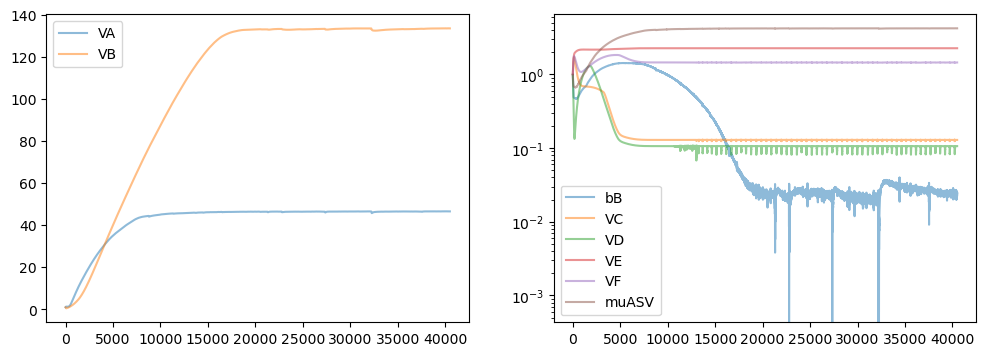

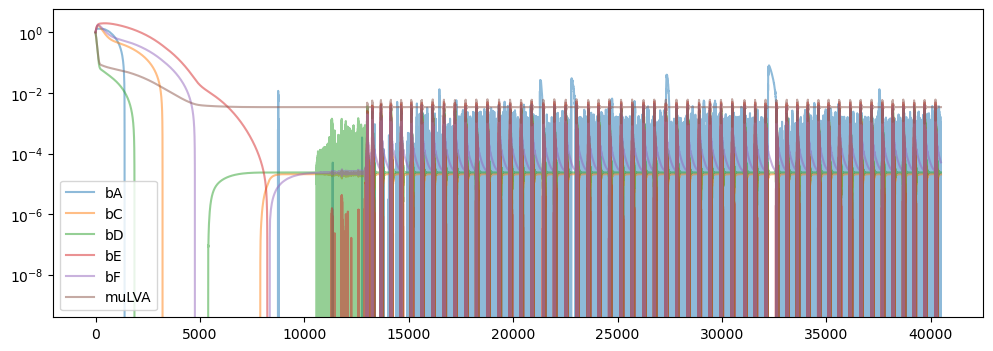

In [66]:
param_name = ["bA", "bB", "bC", "bD", "bE", "bF", "VA", "VB", "VC", "VD", "VE", "VF", "muASV", "muLVA"]
plt.figure(figsize=(12,4));plt.subplot(121)
for i, n in enumerate(param_name):
    if params_est[40491,i] > 20:
        plt.plot(params_est[:40491,i], label=n, alpha=.5)
        
plt.legend();
plt.subplot(122)
for i, n in enumerate(param_name):
    if params_est[40491,i] <= 20 and params_est[40491,i]  >0.01:
        plt.plot(params_est[:40491,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()
plt.figure(figsize=(12,4))
for i, n in enumerate(param_name):
    if params_est[40491,i] <= 0.01:
        plt.plot(params_est[:40491,i], label=n, alpha=.5)
        
plt.legend();plt.yscale('log');plt.show()

In [84]:
np.min(np.sum(losses1, axis=1))

20.423403412623017

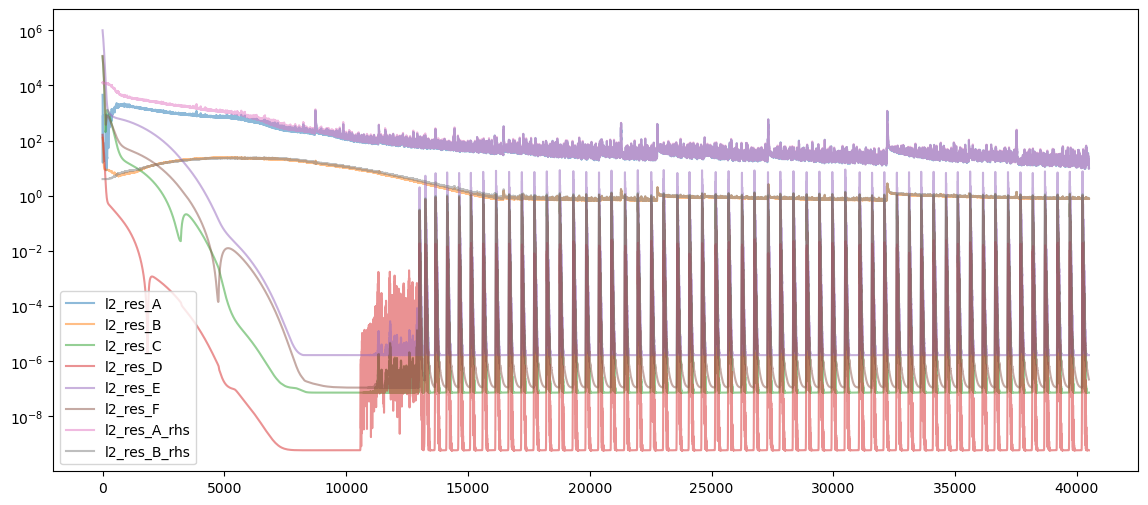

In [87]:
plt.figure(figsize=(14,6))
for i, n in enumerate(names):
    plt.plot(losses1[:40491,i], label=n, alpha=.5)
plt.legend();plt.yscale('log');plt.show()

In [98]:
@tf.function
def grads(pinn, inputs):    
    with tf.GradientTape(persistent=True) as tape:        
        tape.watch(inputs)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(inputs)            
            outputs = pinn.net(inputs)            
        
            Ag = tf.squeeze(outputs[:, 0])
            Bg = tf.squeeze(outputs[:, 1])
            Cg = tf.squeeze(outputs[:, 2])
            Dg = tf.squeeze(outputs[:, 3])
            Eg = tf.squeeze(outputs[:, 4])
            Fg = tf.squeeze(outputs[:, 5])

            grad_A = tape2.gradient(Ag, inputs)
            A_x = grad_A[:, 0]
            A_y = grad_A[:, 1]
            A_t = grad_A[:, 2]

            grad_B = tape2.gradient(Bg, inputs)
            B_x = grad_B[:, 0]
            B_y = grad_B[:, 1]
            B_t = grad_B[:, 2]
            
            grad_C = tape2.gradient(Cg, inputs)
            C_t = grad_C[:, 2]
            
            grad_D = tape2.gradient(Dg, inputs)
            D_t = grad_D[:, 2]
            
            grad_E = tape2.gradient(Eg, inputs)
            E_t = grad_E[:, 2]
            
            grad_F = tape2.gradient(Fg, inputs)
            F_t = grad_F[:, 2]
            

        grad_A_x = tape.gradient(A_x, inputs)
        A_xx = grad_A_x[:, 0]
        grad_A_y = tape.gradient(A_y, inputs)
        A_yy = grad_A_y[:, 1]
        grad_B_x = tape.gradient(B_x, inputs)
        B_xx = grad_B_x[:, 0]
        grad_B_y = tape.gradient(B_y, inputs)
        B_yy = grad_B_y[:, 1]
    return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
            tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
            tf.squeeze(Cg), tf.squeeze(C_t), 
            tf.squeeze(Dg), tf.squeeze(D_t), 
            tf.squeeze(Eg), tf.squeeze(E_t), 
            tf.squeeze(Fg), tf.squeeze(F_t),)                               
#     return (tf.squeeze(Ag), tf.squeeze(A_xx), tf.squeeze(A_yy), tf.squeeze(A_t),
#             tf.squeeze(Bg), tf.squeeze(B_xx), tf.squeeze(B_yy), tf.squeeze(B_t),
#             tf.squeeze(Cg), tf.squeeze(C_t),
#             tf.squeeze(Dg), tf.squeeze(D_t),
#             tf.squeeze(Eg), tf.squeeze(E_t),
#             tf.squeeze(Fg), tf.squeeze(F_t))

def to(arr):
    return arr.numpy().reshape(block_x, block_y)

def plot_state(pinn):
        (A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C, C_t,  D, D_t,  E, E_t,  F, F_t, 
        ) = grads(pinn, obs_X)
        
        A_der = DA*( to(A_xx) + to(A_yy))
        B_der = DB*( to(B_xx) + to(B_yy))

        actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
        actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]
        # X and Y are misoriented
        A_der = A_der
        B_der = B_der
        
        plot_n_im([to(A), c_restricted[0,:, : , -1], to(B), c_restricted[1,:, :  , -1]], 
          ["A", "Actual A", "B", "Actual B"],          
          figsize=(12, 3)); plt.tight_layout()

        A = c_restricted[0,:, : , -1]
        B = c_restricted[1,:, : , -1]

        
        
        plot_n_im([to(A_xx), c_xx[0,x_slice, y_slice , -1], to(A_yy), c_yy[0,x_slice, y_slice  , -1]], 
          ["A_xx", "Actual A_xx", "A_yy", "Actual A_yy"],          
          figsize=(12, 3)); plt.tight_layout()

        plot_n_im([to(B_xx), c_xx[1,x_slice, y_slice  , -1], to(B_yy), c_yy[1,x_slice, y_slice  , -1]],
                  ["B_xx", "Actual B_xx", "B_yy", "Actual B_yy"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(A_t),  c_t[0,x_slice, y_slice , -1],  to(B_t),  c_t[1,x_slice, y_slice , -1]],
                   ["A_t", "Actual A_t", "B_t", "Actual B_t"],          
                   figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(C_t),  c_t[2,x_slice, y_slice , -1],  to(D_t),  c_t[3,x_slice, y_slice , -1]],
                   ["C_t", "Actual C_t", "D_t", "Actual D_t"],          
                   figsize=(12, 3)); plt.tight_layout()
        plot_n_im([to(E_t),  c_t[4,x_slice, y_slice , -1],  to(F_t),  c_t[5,x_slice, y_slice , -1]],
                   ["E_t", "Actual E_t", "F_t", "Actual F_t"],          
                   figsize=(12, 3)); plt.tight_layout()
        
#         plot_n_im([c_t[0,x_slice, y_slice , -1],   c_t[1,x_slice, y_slice, -1]],
#                    ["Actual A_t",  "Actual B_t"],          
#                    figsize=(12, 3)); plt.tight_layout()
        plot_n_im([A_der,  actual_A_der],
                  ["RHS A", "Actual RHS A"],          
                  figsize=(12, 3)); plt.tight_layout()
        plot_n_im([B_der,  actual_B_der],
                  ["RHS B", "Actual RHS B"],          
                  figsize=(12, 3)); plt.tight_layout()
        plt.show()

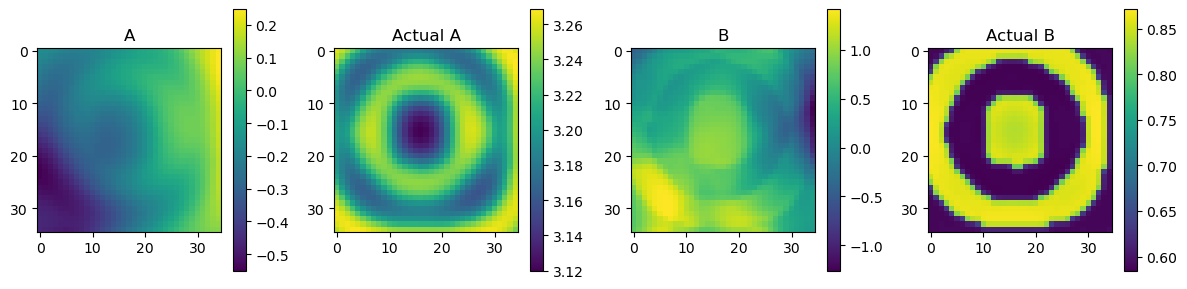

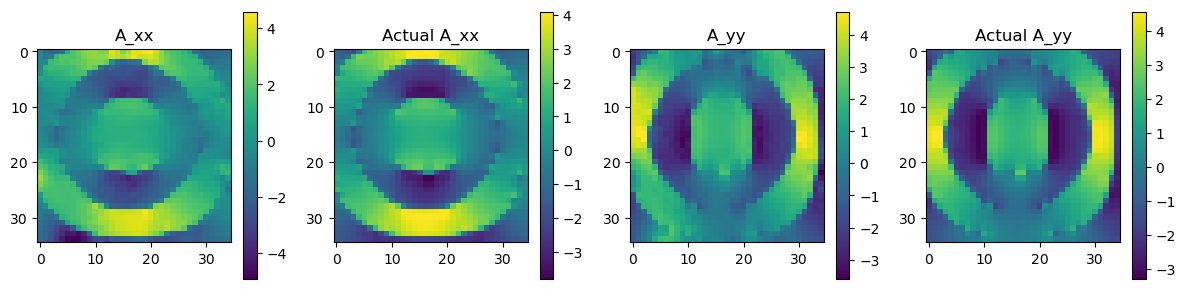

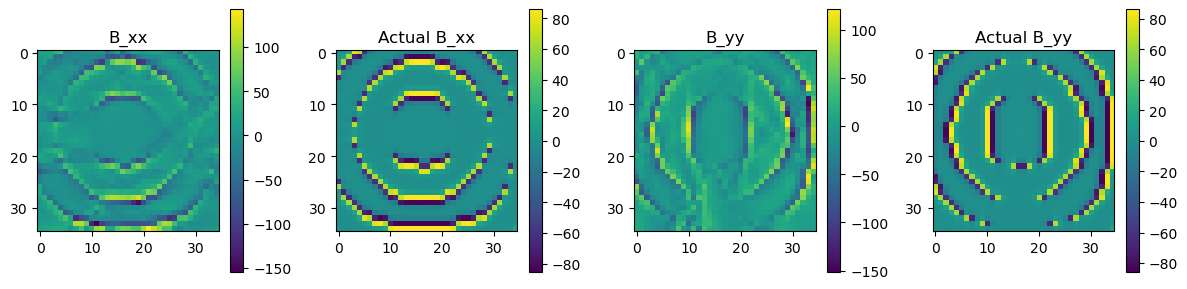

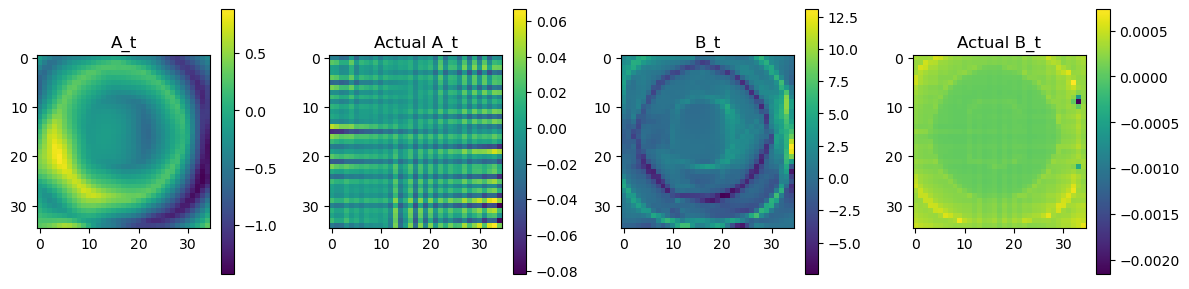

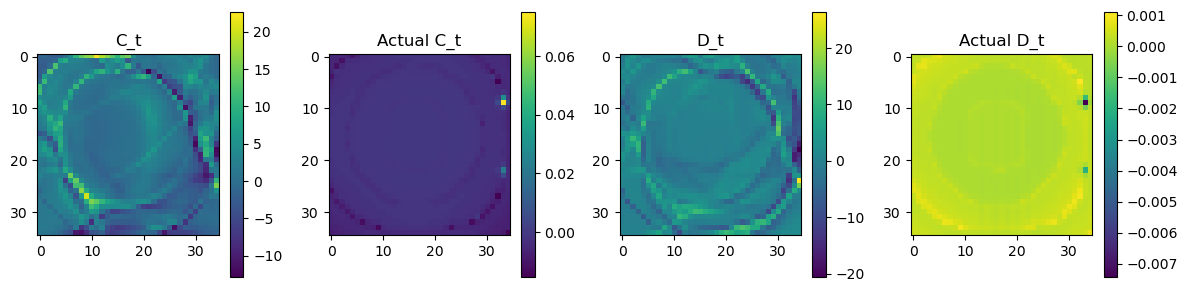

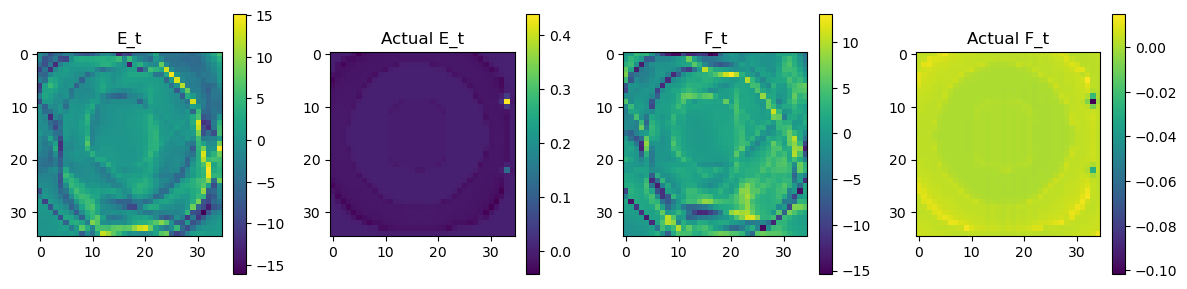

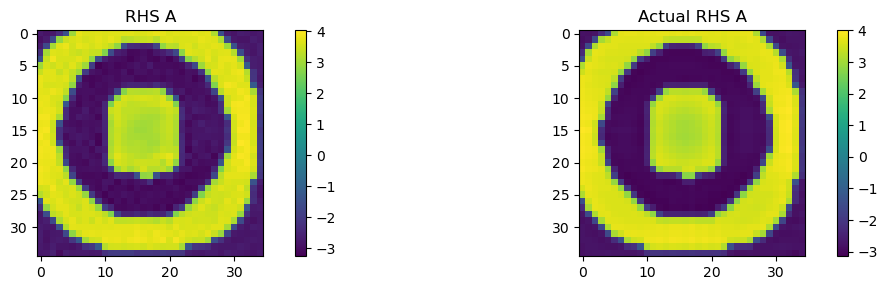

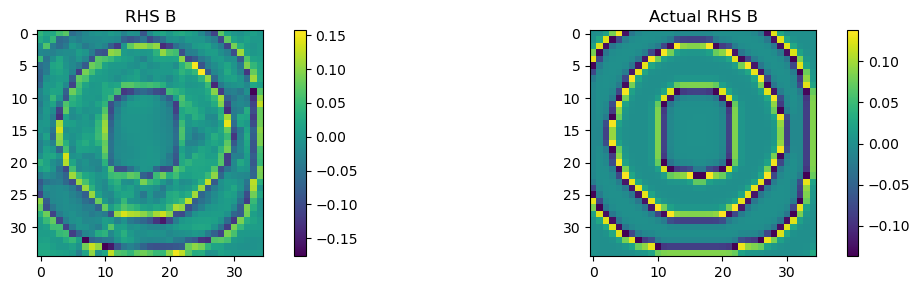

In [99]:
plot_state(pinn1)

In [90]:
(A, A_xx, A_yy, A_t,
         B, B_xx, B_yy, B_t,
         C,  D,  E,  F, 
        ) = grads(pinn1, obs_X)

In [91]:
u_t_act = c_t[0,x_slice, y_slice , -1]
v_t_act = c_t[1,x_slice, y_slice , -1]
print(np.sum(u_t_act**2))
print(np.sum(v_t_act**2))
print(np.sum(ders_t[0, :]**2))
print(np.sum(ders_t[1, :]**2))

0.49224496907994086
6.61899213916773e-05
0.492245
6.6189925e-05


In [92]:
A_der = DA*( to(A_xx) + to(A_yy))
B_der = DB*( to(B_xx) + to(B_yy))

actual_A_der = DA*( c_xx[0,x_slice, y_slice  , -1] + c_yy[0,x_slice, y_slice  , -1])# - to(u_t2)[-1, ...]
actual_B_der = DB*( c_xx[1,x_slice, y_slice  , -1] + c_yy[1,x_slice, y_slice  , -1])# - to(v_t2)[-1, ...]

In [93]:
print(np.sum((A_der-actual_A_der)**2))
print(np.sqrt(np.mean((A_der-actual_A_der)**2)))
print(np.mean(np.abs(A_der-actual_A_der)/np.abs(actual_A_der)))
print(np.sum((B_der-actual_B_der)**2))
print(np.sqrt(np.mean((B_der-actual_B_der)**2)))
print(np.mean(np.abs(B_der-actual_B_der)/np.abs(actual_B_der)))

9.839098999702625
0.08962096602234129
0.023420138305848423
0.7816972925704455
0.025261041918990926
66.5429681245432
